In [1]:
import pandas as pd

In [2]:
res = pd.read_csv('outputs/overall_results.csv')

In [3]:
import os
from ruamel.yaml import YAML


configs = []
for i, row in res.iterrows():
    path = os.path.join("outputs", row['model'], "config.yml")
    yaml = YAML()
    with open(path, 'r') as f:
        config = yaml.load(f)
    config = {k: v["args"][0] if isinstance(v, dict) else v for k, v in config.items()}
    configs.append(config)

In [4]:
df = pd.DataFrame(configs)

In [5]:
df["model"] = df["name"]
merged = pd.merge(
    res,
    df,
    left_on="model",
    right_on="model",
    how="inner",
)

In [6]:
complexity = pd.read_csv("outputs/complexity.csv")
merged = pd.merge(
    merged,
    complexity,
    left_on="model",
    right_on="model",
    how="inner",
)

In [7]:
filtered = merged[
    merged["scheduler"] == "ReduceLROnPlateau"
][["input_list", "name", "no_kan", "f1_0", "f1_1", "f1_2", "avg_f1", "GFLOPs", "params"]]

best_scores_idx = filtered.groupby(["input_list", "no_kan"])["avg_f1"].idxmax()
best_scores = filtered.loc[best_scores_idx]
best_scores[["f1_0", "f1_1", "f1_2", "avg_f1"]] = best_scores[["f1_0", "f1_1", "f1_2", "avg_f1"]].round(4) * 100
best_scores["input_list"] = best_scores["input_list"].apply(lambda x: x.split(",")[-1])
best_scores["MParams"] = best_scores["params"].apply(lambda x: f"{x / 1e6:.4f}")
best_scores["flops"] = best_scores["GFLOPs"]
best_scores["GFLOPs"] = best_scores["GFLOPs"].apply(lambda x: f"{x:.4f}")
best_scores["Model"] = best_scores.apply(lambda row: ("UNet " if row["no_kan"] else "UKAN ") + str(row["input_list"]), axis=1)
best_scores["architecture"] = best_scores.apply(
    lambda row: "UNet" if row["no_kan"] else "UKAN", axis=1
)
best_scores["variant"] = best_scores.apply(
    lambda row: row["input_list"].split(",")[-1], axis=1
).astype(int)
# best_scores = best_scores.sort_values(
#     by=["architecture","variant"],
#     ascending=[True, True]
# )
best_scores = best_scores.sort_values(
    by=["flops"],
    ascending=[True]
)
refined = best_scores[["Model", "f1_0", "f1_1", "f1_2", "avg_f1", "MParams", "GFLOPs"]]
refined

,Model,f1_0,f1_1,f1_2,avg_f1,MParams,GFLOPs
10,UNet 8,98.51,77.26,16.57,64.11,0.0075,0.0708
9,UNet 16,98.59,75.33,20.69,64.87,0.0129,0.0749
14,UKAN 8,98.49,78.22,26.79,67.83,0.0143,0.0905
15,UKAN 16,98.64,73.82,5.15,59.20,0.0268,0.1004
8,UNet 32,97.95,68.72,35.84,67.50,0.0471,0.2619
13,UKAN 32,98.51,76.71,15.10,63.44,0.1030,0.3641
4,UNet 64,98.51,82.54,66.97,82.67,0.1795,0.9722
2,UKAN 64,98.64,84.64,71.41,84.90,0.4036,1.3812
6,UNet 128,98.61,83.87,71.42,84.63,0.7001,3.7383
1,UKAN 128,98.82,86.95,73.22,86.33,1.5976,5.3741


In [8]:
from tabulate import tabulate
print(tabulate(refined, headers='keys', tablefmt='latex', showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 Model    &   f1\_0 &   f1\_1 &   f1\_2 &   avg\_f1 &   MParams &   GFLOPs \\
\hline
 UNet 8   &  98.51 &  77.26 &  16.57 &    64.11 &    0.0075 &   0.0708 \\
 UNet 16  &  98.59 &  75.33 &  20.69 &    64.87 &    0.0129 &   0.0749 \\
 UKAN 8   &  98.49 &  78.22 &  26.79 &    67.83 &    0.0143 &   0.0905 \\
 UKAN 16  &  98.64 &  73.82 &   5.15 &    59.2  &    0.0268 &   0.1004 \\
 UNet 32  &  97.95 &  68.72 &  35.84 &    67.5  &    0.0471 &   0.2619 \\
 UKAN 32  &  98.51 &  76.71 &  15.1  &    63.44 &    0.103  &   0.3641 \\
 UNet 64  &  98.51 &  82.54 &  66.97 &    82.67 &    0.1795 &   0.9722 \\
 UKAN 64  &  98.64 &  84.64 &  71.41 &    84.9  &    0.4036 &   1.3812 \\
 UNet 128 &  98.61 &  83.87 &  71.42 &    84.63 &    0.7001 &   3.7383 \\
 UKAN 128 &  98.82 &  86.95 &  73.22 &    86.33 &    1.5976 &   5.3741 \\
 UNet 256 &  98.6  &  84.78 &  70.79 &    84.72 &    2.7646 &  14.652  \\
 UKAN 256 &  98.74 &  85.3  &  70.02 &    84.69 &    6.3567 &  21.195

In [9]:
import os
import torch
import lovely_tensors as lt
import numpy as np
from PIL import Image
lt.monkey_patch()

In [10]:
base_outdir = f"outputs/{best_scores.iloc[0]["name"]}/out_val"
images = os.listdir(base_outdir)
outs = set(map(lambda x: x.split(".")[0] if "." in x else x, map(lambda x: x.split("_")[1], images)))
outs = list(outs)

outdirs = []
for idx, row in best_scores.iterrows():
    outdir = f"outputs/{row["name"]}/out_val"
    outdirs.append(outdir)

In [103]:
selected_out = 55

In [104]:
best_scores["pred"] = best_scores.apply(
    lambda row: Image.open(f"outputs/{row["name"]}/out_val/003_{outs[selected_out]}_pred.png"),
    axis=1
)
def green_to_blue(img):
    """
    Substitute all green pixels in a PIL image with blue ones.
    A pixel is considered 'green' if its G channel is strictly greater than both R and B.

    Args:
        img (PIL.Image.Image): Input image.

    Returns:
        PIL.Image.Image: Image with green pixels replaced by blue.
    """
    arr = np.array(img)
    # Identify green pixels: G > R and G > B
    green_mask = (arr[..., 1] > arr[..., 0]) & (arr[..., 1] > arr[..., 2])
    # Replace green pixels with blue [0, 0, 255]
    arr[green_mask] = [0, 0, 255]
    return Image.fromarray(arr)

best_scores["pred"] = best_scores["pred"].apply(green_to_blue)

In [105]:
img = f"{base_outdir}/003_{outs[selected_out]}.png"
gt = f"{base_outdir}/003_{outs[selected_out]}_gt.png"

img = Image.open(img)
gt = Image.open(gt)
gt = green_to_blue(gt)

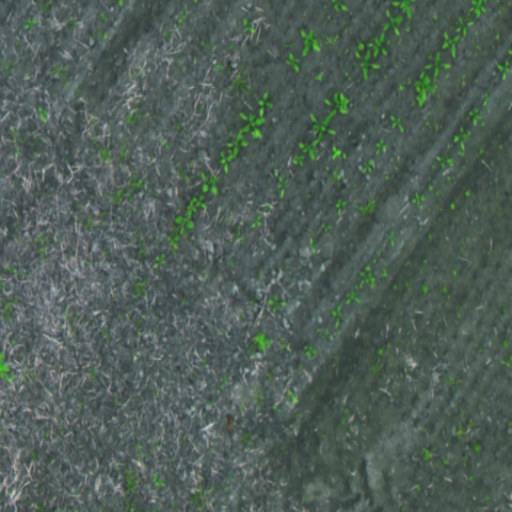

In [106]:
img

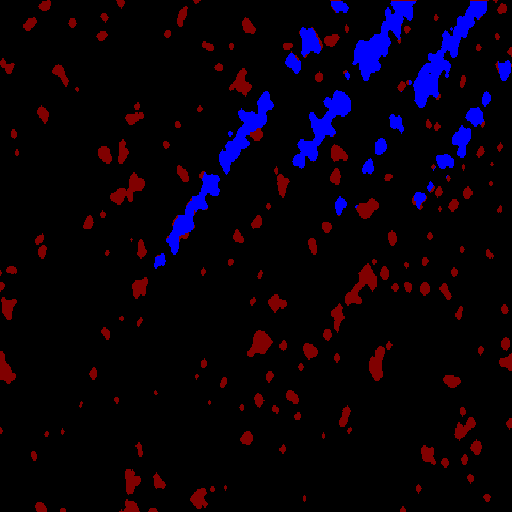

In [107]:
gt

In [109]:
selected_models = [
    "UNet 16",
    "UKAN 8",
    "UNet 512",
    "UKAN 128",
]

Model: UNet 16, F1: 64.8700, MParams: 0.0129, GFLOPs: 0.0749


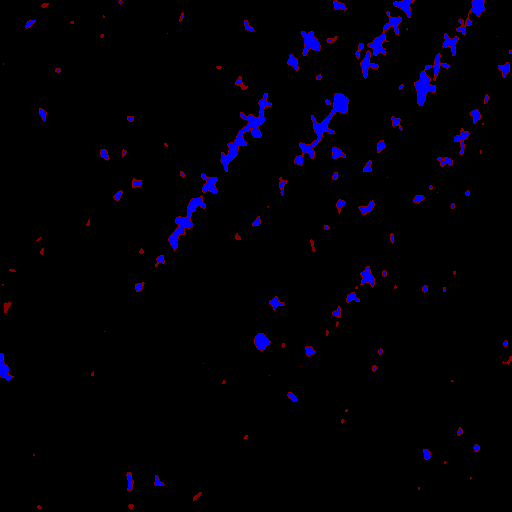

Model: UKAN 8, F1: 67.8300, MParams: 0.0143, GFLOPs: 0.0905


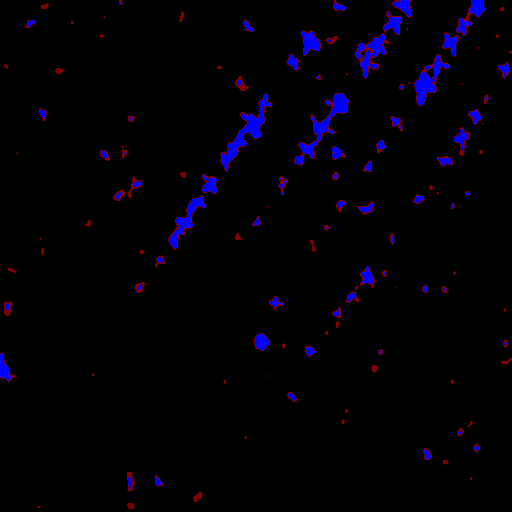

Model: UKAN 128, F1: 86.3300, MParams: 1.5976, GFLOPs: 5.3741


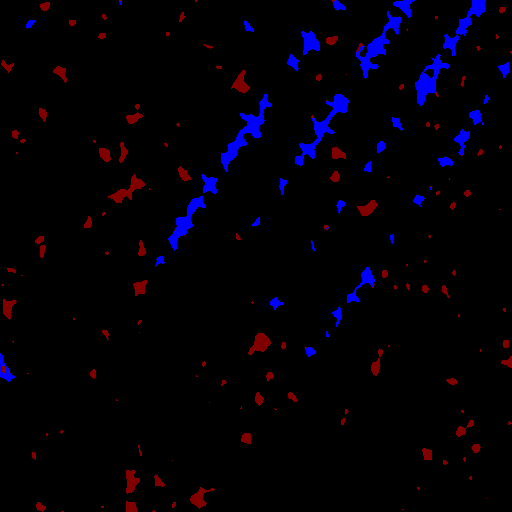

Model: UNet 512, F1: 86.0500, MParams: 10.9866, GFLOPs: 58.0057


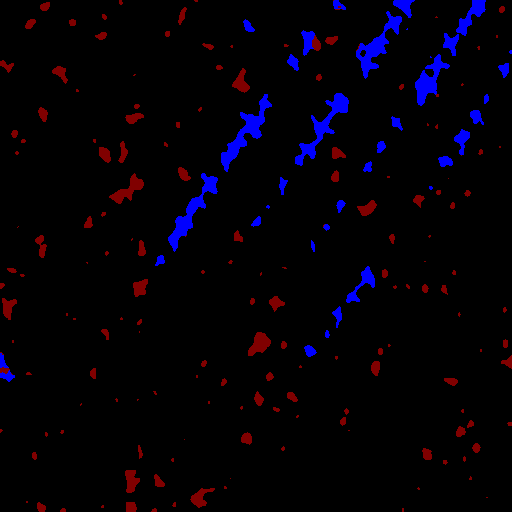

In [110]:
for row in best_scores.itertuples():
    if row.Model not in selected_models:
        continue
    pred = row.pred
    
    print(f"Model: {row.Model}, F1: {row.avg_f1:.4f}, MParams: {row.MParams}, GFLOPs: {row.GFLOPs}")
    display(row.pred)

In [111]:
folder = "qualit"
os.makedirs(folder, exist_ok=True)

img.save(os.path.join(folder, f"{selected_out}_img.png"))
gt.save(os.path.join(folder, f"{selected_out}_gt.png"))
for row in best_scores.itertuples():
    if row.Model not in selected_models:
        continue
    pred = row.pred
    print(f"Model: {row.Model}, F1: {row.avg_f1:.4f}, MParams: {row.MParams}, GFLOPs: {row.GFLOPs}")
    pred.save(f"{folder}/{selected_out}_{row.Model}.png")

Model: UNet 16, F1: 64.8700, MParams: 0.0129, GFLOPs: 0.0749
Model: UKAN 8, F1: 67.8300, MParams: 0.0143, GFLOPs: 0.0905
Model: UKAN 128, F1: 86.3300, MParams: 1.5976, GFLOPs: 5.3741
Model: UNet 512, F1: 86.0500, MParams: 10.9866, GFLOPs: 58.0057
